In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import progressbar
import astropy.cosmology as apc
from sphviewer.tools import QuickView
from sphviewer.tools import Blend

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [5]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [6]:
TdayTotalIDs = sim['SnapNumber_128/PartType4/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [7]:
# and now to locate the firts pericentre, and the distance to the centre.

def getperi(gal, center):
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+center)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    r, thesnap, rphys = [], [], []
    
    proy = []
    for m, mC in zip(mtree, mtreeC):
        snap, idd = split_unique_id(int(m))
        snapC, iddC = split_unique_id(int(mC))
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]

        galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        cenPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        
        vec =  galPos - cenPos
        rad = np.sqrt(np.sum(vec**2.))
        
        r.append(rad/r200)
        rphys.append(rad)
        thesnap.append(snap)
        proy.append(vec)
        
    r, rphys, thesnap = np.array(r), np.array(rphys), np.array(thesnap)
    proy = np.array(proy)
    
    
    ir = np.where(r<2.) # no further, just in case
    
    r, rphys, thesnap = r[ir], rphys[ir], thesnap[ir]
    proy = proy[ir]
    
    angles = []
    for i in range(len(proy)-1):
        dot = np.dot(proy[i], proy[i-1])
        cos = dot/(rphys[i]*rphys[i-1])
        if cos>1 and cos<1.001: # a failsafe
            cos=1.
        angles.append(np.arccos(cos))
        
    angles = np.array(angles)
        
    # this is backwards, it starts in teh future and it moves formward.
    r, rphys, thesnap = np.flip(r), np.flip(rphys), np.flip(thesnap)
    
    angles = np.flip(angles)
    
    pre, r0 = 0, rphys[0]
    for i, rr in enumerate(rphys[1:]):
        if rr>r0:
            break
        else:
            r0 = rr
            pre = i+1
            
            
    physD, Snap = rphys[pre], thesnap[pre]
    angles = angles[pre-1:]
    
    mmr = rphys.min()
    firstsnap = thesnap.min()
    Nturn = np.sum(angles)/(2.*np.pi)
    
    return physD, Snap, mmr, firstsnap, Nturn

In [8]:
# let's try this
gal, center = 4470, 4469
physD, Snap, mmr, firstsnap, Nturn = getperi(gal, center)

firstsnap, Snap, Nturn

(97, 101, 0.9278289839658819)

In [9]:
uniqueID = int(128*1e6+gal)
stree = networkx.dfs_tree(trees, str(uniqueID))
mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
uniqueIDC = int(128*1e6+center)
streeC = networkx.dfs_tree(trees, str(uniqueIDC))
mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
x, y, z = [], [], []
for m, mC in zip(mtree, mtreeC):
    snap, idd = split_unique_id(int(m))
    snapC, iddC = split_unique_id(int(mC))
        
    galPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
    cenPos = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
        
    vec =  galPos - cenPos
    
    x.append(vec[0])
    y.append(vec[1])
    z.append(vec[2])
    
    if snap==Snap:
        x0, y0, z0 = vec[0], vec[1], vec[2]
        
x, y, z = np.array(x), np.array(y), np.array(z)

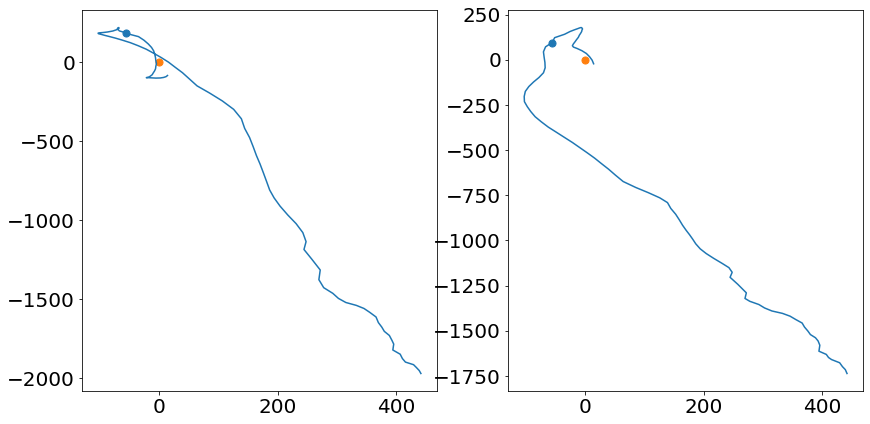

In [10]:
pl.figure(figsize=(14, 7))

pl.subplot(1, 2, 1)

pl.plot(x, y)
pl.scatter(x0, y0, marker='o', s=50)
pl.scatter(0, 0, marker='o', s=50)


pl.subplot(1, 2, 2)

pl.plot(x, z)
pl.scatter(x0, z0, marker='o', s=50)
pl.scatter(0, 0, marker='o', s=50)

In [11]:
# ok, lets do a new version of the thing that measures the thing by snapshot, and return mass and stuff

def getAllLastP(fofID, centralID, snapmax):
    
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, snaplist, MassList, AbundList = [], [], [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        
        if snap>=snapmax:
            tempOff = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
            if tempOff[0]>= 0 and tempOff[1]>=0:
                # now we keep only theones between r_optical

    #             rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

    #             posPart = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
    #             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

    #             xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

    #             rr = np.sqrt(xx**2+yy**2+zz**2)

    #             ik = np.where(rr<rop)[0]

                tempIds = sim['SnapNumber_{}/PartType4/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
    #             tempIds = tempIds[ik]

                GMass = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][tempOff[0]:tempOff[1]]
                GAbund = sim['SnapNumber_{}/PartType4/Abundances'.format(snap)][tempOff[0]:tempOff[1]]

                Idlist.extend(list(tempIds))
                snaplist.extend([snap]*tempIds.size)
                MassList.extend(list(GMass))
                AbundList.extend(list(GAbund))

            

    Idlist = np.array(Idlist)
    snaplist = np.array(snaplist)
    MassList = np.array(MassList)
    AbundList = np.array(AbundList)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snaplist = snaplist[Idunique]
    MassList = MassList[Idunique]
    AbundList = AbundList[Idunique]
    
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][fofID].astype('int')
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
#     rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
#     posPart = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
#     xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
#     rr = np.sqrt(xx**2+yy**2+zz**2)
            
#     ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType4/ParticleIDs'][TdayOff[0]:TdayOff[1]]
#     TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    Idlist_ = Idlist[iidex_]
    snaplist_ = snaplist[iidex_]
    MassList_ = MassList[iidex_]
    AbundList_ = AbundList[iidex_]
    
    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    Massorder = np.zeros(IndexT_.size)
    Abundorder = np.zeros((IndexT_.size, 12))
    
    snaporder[is1] = snaplist_[is2]
    Massorder[is1] = MassList_[is2]
    Abundorder[is1] = AbundList_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0] # idk, for now no
#     IndexT_near_ = IndexT_near[icut2]

    return snaporder, Massorder, Abundorder

In [12]:
# lets see if do not crash, at least, but how to know if thsi is working
snaporder, Massorder, Abundorder = getAllLastP(4471, 4469, 92)

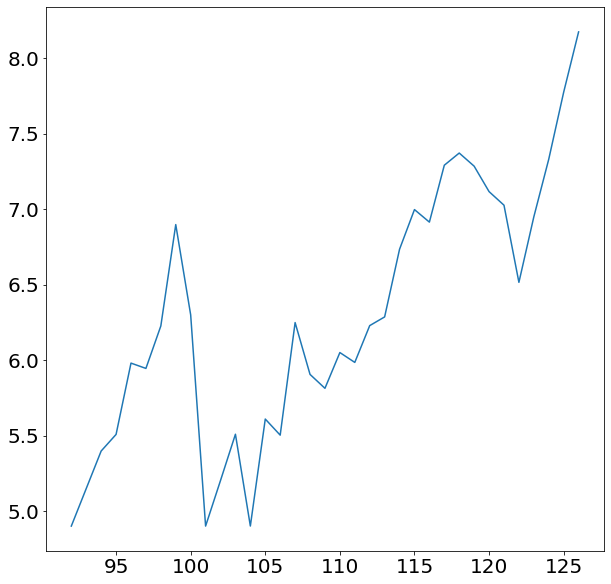

In [13]:
# lets see if at least teh amount of material increases with time
snapu = np.unique(snaporder)

snapMass = []
for s in snapu:
    i = np.where(snaporder==s)
    tmass = Massorder[i]
    snapMass.append(np.log10(np.sum(tmass)*1e10))
    
snapMass = np.array(snapMass)

pl.figure(figsize=(10,10))

pl.plot(snapu, snapMass)

In [14]:
# ok, i think i got it, lets see
gal, cen = 4470, 4469

physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
snaporder, Massorder, Abundorder = getAllLastP(gal, cen, firstsnap)

ipre = np.where(snaporder<Snap)
ipost = np.where(snaporder>=Snap)

MassPre = np.sum(Massorder[ipre])
MassPost = np.sum(Massorder[ipost])

MassPost/MassPre, np.log10(MassPre*1e10), np.log10(MassPost*1e10), Snap, mmr, physD, Nturn

(10.408644095958282,
 6.792370117351249,
 7.809764276256954,
 101,
 88.55082,
 215.69713,
 0.9278289839658819)

In [15]:
listOfGal = np.array([4338, 4339, 4341, 4343, 4470, 4471, 4473, 4474])
listOfCen = np.array([4337, 4337, 4337, 4337, 4469, 4469, 4469, 4469])

In [16]:
# i think i need to measure the number of laps, but later.

ratio = []
MassRatio = []
minDist = []
periDist = []
NLaps = []
difFeH = []
difOFe = []

bar = progressbar.ProgressBar(max_value=8)

c = 0

for gal, cen in zip(listOfGal, listOfCen):
    physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
    snaporder, Massorder, Abundorder = getAllLastP(gal, cen, firstsnap)

    ipre = np.where(snaporder<Snap)
    ipost = np.where(snaporder>=Snap)

    AbundPre = Abundorder[ipre]
    AbundPost = Abundorder[ipost]
    
    FeHPre = np.log10((AbundPre[:,4]/FeMass)/(AbundPre[:,6]/HMass)) - NfeNhe_sun
    FeHPost = np.log10((AbundPost[:,4]/FeMass)/(AbundPost[:,6]/HMass)) - NfeNhe_sun

    iFpre = np.where((np.isnan(FeHPre)==False) & (np.isinf(FeHPre)==False))
    iFpost = np.where((np.isnan(FeHPost)==False) & (np.isinf(FeHPost)==False))
    
    FeHPre = FeHPre[iFpre]
    FeHPost = FeHPost[iFpost]
    
    OFePre = np.log10((AbundPre[:,3]/OMass)/(AbundPre[:,4]/FeMass)) - NoNfe_sun
    OFePost = np.log10((AbundPost[:,3]/OMass)/(AbundPost[:,4]/FeMass)) - NoNfe_sun
    
    iOpre = np.where((np.isnan(OFePre)==False) & (np.isinf(OFePre)==False))
    iOpost = np.where((np.isnan(OFePost)==False) & (np.isinf(OFePost)==False))
    
    OFePre = OFePre[iOpre]
    OFePost = OFePost[iOpost]
    
    difFeH_pp = np.median(FeHPost) - np.median(FeHPre)
    difOFe_pp = np.median(OFePost) - np.median(OFePre)
    
    difFeH.append(difFeH_pp)
    difOFe.append(difOFe_pp)
    
    MassPre = np.sum(Massorder[ipre])
    MassPost = np.sum(Massorder[ipost])
    
    ratio.append(MassPost/MassPre)
    
    
    tempOff = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][gal].astype('int')
    rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][gal]

    posPart = sim['SnapNumber_128/PartType4/Coordinates'][tempOff[0]:tempOff[1]]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][gal]

    xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

    rr = np.sqrt(xx**2+yy**2+zz**2)

    ik = np.where(rr<rop)[0]
    GalMass = sim['SnapNumber_128/PartType4/Masses'][tempOff[0]:tempOff[1]]
    GalMass = GalMass[ik]
    
    tempOffC = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][cen].astype('int')
    ropC = sim['SnapNumber_128/SubGroups/OpticalRadius'][cen]

    posPartC = sim['SnapNumber_128/PartType4/Coordinates'][tempOffC[0]:tempOffC[1]]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]

    xxC, yyC, zzC = posPartC[:,0] - posCen[0], posPartC[:,1] - posCen[1], posPartC[:,2] - posCen[2]

    rrC = np.sqrt(xxC**2+yyC**2+zzC**2)

    ikC = np.where(rrC<ropC)[0]
    CenMass = sim['SnapNumber_128/PartType4/Masses'][tempOffC[0]:tempOffC[1]]
    CenMass = CenMass[ikC]
    
    MassRatio.append(np.sum(GalMass)/np.sum(CenMass))
    
    minDist.append(mmr)
    periDist.append(physD)
    NLaps.append(Nturn)
    
    c += 1
    bar.update(c)
    

ratio = np.array(ratio)
MassRatio = np.array(MassRatio)
minDist = np.array(minDist)
periDist = np.array(periDist)
NLaps = np.array(NLaps)
difFeH = np.array(difFeH)
difOFe = np.array(difOFe)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
 87% (7 of 8) |######################    | Elapsed Time: 0:00:09 ETA:   0:00:01/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_sca

Text(0, 0.5, '$M_{post}/M_{pre}$')

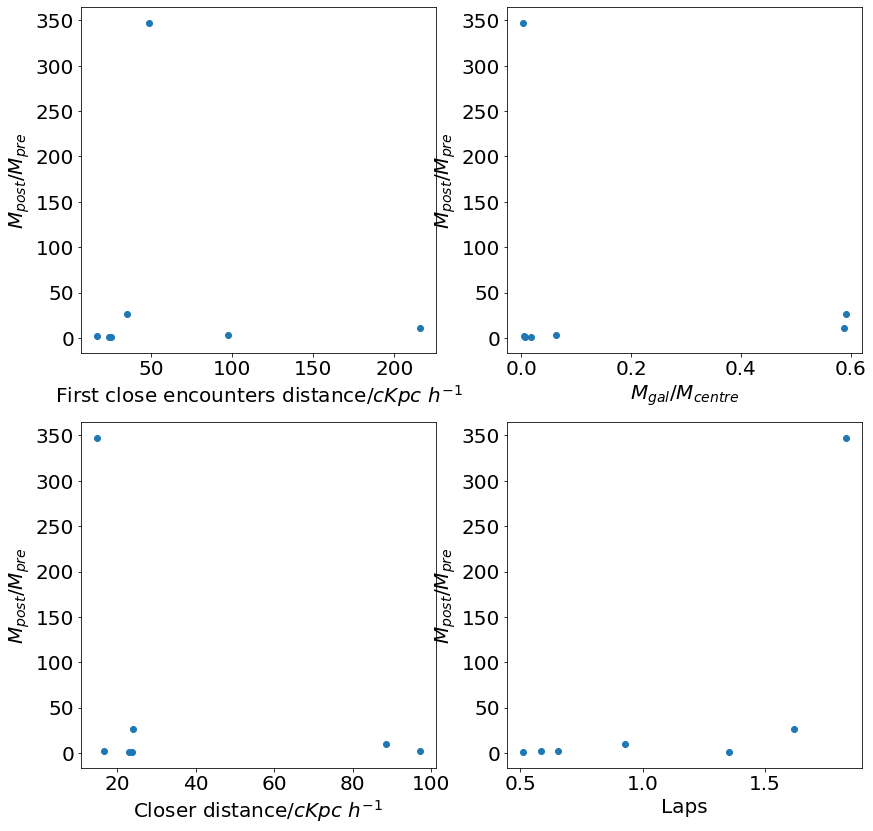

In [17]:
pl.figure(figsize=(14, 14))

pl.subplot(2, 2, 1)

pl.plot(periDist, ratio, marker='o', ls=' ')

pl.xlabel('First close encounters distance/$cKpc\,\,h^{-1}$')
pl.ylabel('$M_{post}/M_{pre}$')

pl.subplot(2, 2, 2)

pl.plot(MassRatio, ratio, marker='o', ls=' ')

pl.xlabel('$M_{gal}/M_{centre}$')
pl.ylabel('$M_{post}/M_{pre}$')


pl.subplot(2, 2, 3)

pl.plot(minDist, ratio, marker='o', ls=' ')

pl.xlabel('Closer distance/$cKpc\,\,h^{-1}$')
pl.ylabel('$M_{post}/M_{pre}$')

pl.subplot(2, 2, 4)

pl.plot(NLaps, ratio, marker='o', ls=' ')

pl.xlabel('Laps')
pl.ylabel('$M_{post}/M_{pre}$')

In [18]:
def getAllLastP_optical(fofID, centralID, snapmax):
    
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist, snaplist, MassList, AbundList = [], [], [], []
    
    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        
        if snap>=snapmax:
            tempOff = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
            if tempOff[0]>= 0 and tempOff[1]>=0:
                # now we keep only theones between r_optical

                rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

                posPart = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
                posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

                xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

                rr = np.sqrt(xx**2+yy**2+zz**2)

                ik = np.where(rr<rop)[0]

                tempIds = sim['SnapNumber_{}/PartType4/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
                tempIds = tempIds[ik]

                GMass = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][tempOff[0]:tempOff[1]]
                GAbund = sim['SnapNumber_{}/PartType4/Abundances'.format(snap)][tempOff[0]:tempOff[1]]

                Idlist.extend(list(tempIds))
                snaplist.extend([snap]*tempIds.size)
                MassList.extend(list(GMass))
                AbundList.extend(list(GAbund))

            

    Idlist = np.array(Idlist)
    snaplist = np.array(snaplist)
    MassList = np.array(MassList)
    AbundList = np.array(AbundList)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    snaplist = snaplist[Idunique]
    MassList = MassList[Idunique]
    AbundList = AbundList[Idunique]
    
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][fofID].astype('int')
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    rop = sim['SnapNumber_128/SubGroups/OpticalRadius'][fofID]
    
    posPart = sim['SnapNumber_128/PartType4/Coordinates'][TdayOff[0]:TdayOff[1]]
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]
            
    rr = np.sqrt(xx**2+yy**2+zz**2)
            
    ik = np.where(rr<rop)[0]
    
    TdayIDs = sim['SnapNumber_128/PartType4/ParticleIDs'][TdayOff[0]:TdayOff[1]]
    TdayIDs = TdayIDs[ik]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    Idlist_ = Idlist[iidex_]
    snaplist_ = snaplist[iidex_]
    MassList_ = MassList[iidex_]
    AbundList_ = AbundList[iidex_]
    
    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    snaporder = np.zeros(IndexT_.size)
    Massorder = np.zeros(IndexT_.size)
    Abundorder = np.zeros((IndexT_.size, 12))
    
    snaporder[is1] = snaplist_[is2]
    Massorder[is1] = MassList_[is2]
    Abundorder[is1] = AbundList_[is2]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
#     distance = 200
    
#     posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

#     LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
#     dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
#     distToC = np.sqrt(dx**2+dy**2+dz**2)

#     icut = np.where(distToC<distance)[0]
#     IndexT_near = IndexT_[icut] # this is the almost final list of particles ids, but not yet
    IndexT_near = IndexT_
    
#     LostNow = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     icut2 = np.where(LostNow==-1)[0] # idk, for now no
#     IndexT_near_ = IndexT_near[icut2]

    return snaporder, Massorder, Abundorder

In [19]:
ratio_optical = []
difFeH_optical = []
difOFe_optical = []

bar = progressbar.ProgressBar(max_value=8)

c = 0

for gal, cen in zip(listOfGal, listOfCen):
    physD, Snap, mmr, firstsnap, Nturn = getperi(gal, cen)
    snaporder, Massorder, Abundorder = getAllLastP_optical(gal, cen, firstsnap)

    ipre = np.where(snaporder<Snap)
    ipost = np.where(snaporder>=Snap)

    AbundPre = Abundorder[ipre]
    AbundPost = Abundorder[ipost]
    
    FeHPre = np.log10((AbundPre[:,4]/FeMass)/(AbundPre[:,6]/HMass)) - NfeNhe_sun
    FeHPost = np.log10((AbundPost[:,4]/FeMass)/(AbundPost[:,6]/HMass)) - NfeNhe_sun
    
    iFpre = np.where((np.isnan(FeHPre)==False) & (np.isinf(FeHPre)==False))
    iFpost = np.where((np.isnan(FeHPost)==False) & (np.isinf(FeHPost)==False))
    
    FeHPre = FeHPre[iFpre]
    FeHPost = FeHPost[iFpost]
    
    OFePre = np.log10((AbundPre[:,3]/OMass)/(AbundPre[:,4]/FeMass)) - NoNfe_sun
    OFePost = np.log10((AbundPost[:,3]/OMass)/(AbundPost[:,4]/FeMass)) - NoNfe_sun
    
    iOpre = np.where((np.isnan(OFePre)==False) & (np.isinf(OFePre)==False))
    iOpost = np.where((np.isnan(OFePost)==False) & (np.isinf(OFePost)==False))
    
    OFePre = OFePre[iOpre]
    OFePost = OFePost[iOpost]
    
    difFeH_pp = np.median(FeHPost) - np.median(FeHPre)
    difOFe_pp = np.median(OFePost) - np.median(OFePre)
    
    difFeH_optical.append(difFeH_pp)
    difOFe_optical.append(difOFe_pp)
    
    
    MassPre = np.sum(Massorder[ipre])
    MassPost = np.sum(Massorder[ipost])
    
    ratio_optical.append(MassPost/MassPre)

    c += 1
    bar.update(c)
    

ratio_optical = np.array(ratio_optical)

difFeH_optical = np.array(difFeH_optical)
difOFe_optical = np.array(difOFe_optical)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
100% (8 of 8) |##########################| Elapsed Time: 0:00:08 ETA:  00:00:00

Text(0, 0.5, '$\\log(M_{post}/M_{pre})$')

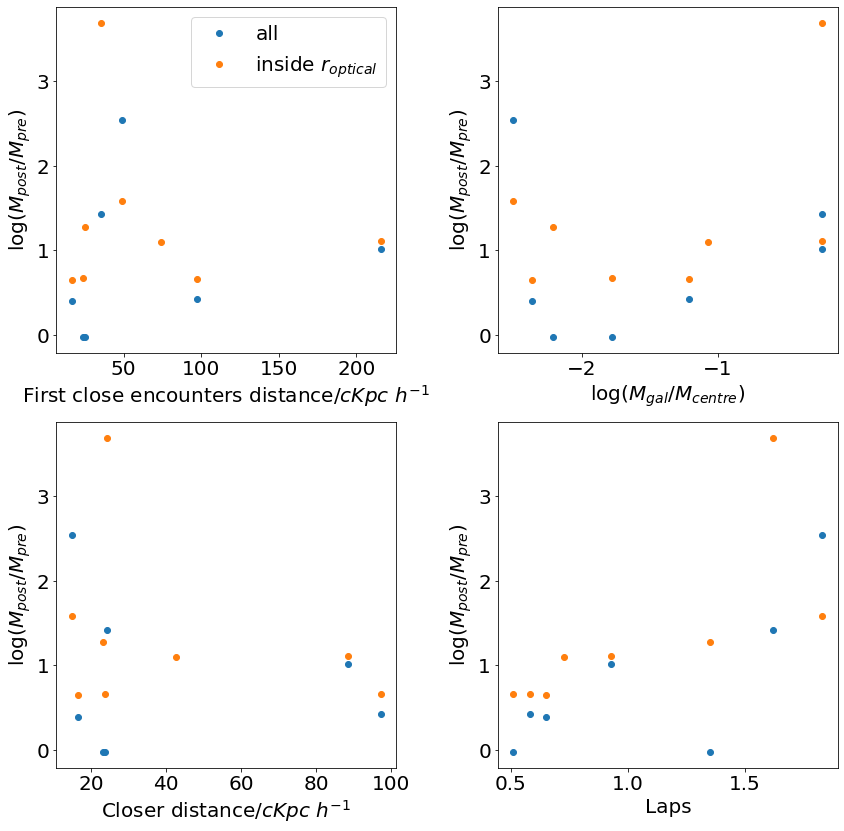

In [20]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.3)

pl.subplot(2, 2, 1)

pl.plot(periDist, np.log10(ratio), marker='o', ls=' ', label='all')
pl.plot(periDist, np.log10(ratio_optical), marker='o', ls=' ', label='inside $r_{optical}$')

pl.legend(loc='best')

pl.xlabel('First close encounters distance/$cKpc\,\,h^{-1}$')
pl.ylabel('$\log(M_{post}/M_{pre})$')

pl.subplot(2, 2, 2)

pl.plot(np.log10(MassRatio), np.log10(ratio), marker='o', ls=' ')
pl.plot(np.log10(MassRatio), np.log10(ratio_optical), marker='o', ls=' ')

pl.xlabel('$\log(M_{gal}/M_{centre})$')
pl.ylabel('$\log(M_{post}/M_{pre})$')

pl.subplot(2, 2, 3)

pl.plot(minDist, np.log10(ratio), marker='o', ls=' ')
pl.plot(minDist, np.log10(ratio_optical), marker='o', ls=' ')

pl.xlabel('Closer distance/$cKpc\,\,h^{-1}$')
pl.ylabel('$\log(M_{post}/M_{pre})$')

pl.subplot(2, 2, 4)

pl.plot(NLaps, np.log10(ratio), marker='o', ls=' ')
pl.plot(NLaps, np.log10(ratio_optical), marker='o', ls=' ')

pl.xlabel('Laps')
pl.ylabel('$\log(M_{post}/M_{pre})$')

Text(0, 0.5, '[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

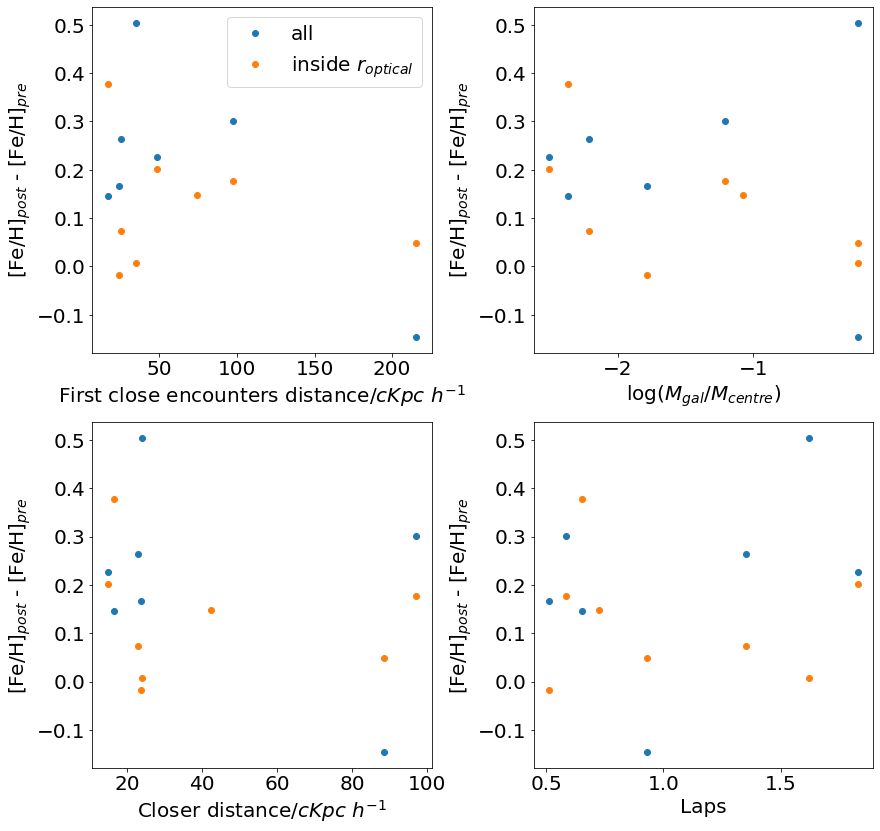

In [21]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.3)

pl.subplot(2, 2, 1)

pl.plot(periDist, difFeH, marker='o', ls=' ', label='all')
pl.plot(periDist, difFeH_optical, marker='o', ls=' ', label='inside $r_{optical}$')

pl.legend(loc='best')

pl.xlabel('First close encounters distance/$cKpc\,\,h^{-1}$')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

pl.subplot(2, 2, 2)

pl.plot(np.log10(MassRatio), difFeH, marker='o', ls=' ')
pl.plot(np.log10(MassRatio), difFeH_optical, marker='o', ls=' ')

pl.xlabel('$\log(M_{gal}/M_{centre})$')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

pl.subplot(2, 2, 3)

pl.plot(minDist, difFeH, marker='o', ls=' ')
pl.plot(minDist, difFeH_optical, marker='o', ls=' ')

pl.xlabel('Closer distance/$cKpc\,\,h^{-1}$')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

pl.subplot(2, 2, 4)

pl.plot(NLaps, difFeH, marker='o', ls=' ')
pl.plot(NLaps, difFeH_optical, marker='o', ls=' ')

pl.xlabel('Laps')
pl.ylabel('[Fe/H]$_{post}$ - [Fe/H]$_{pre}$')

Text(0, 0.5, '[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

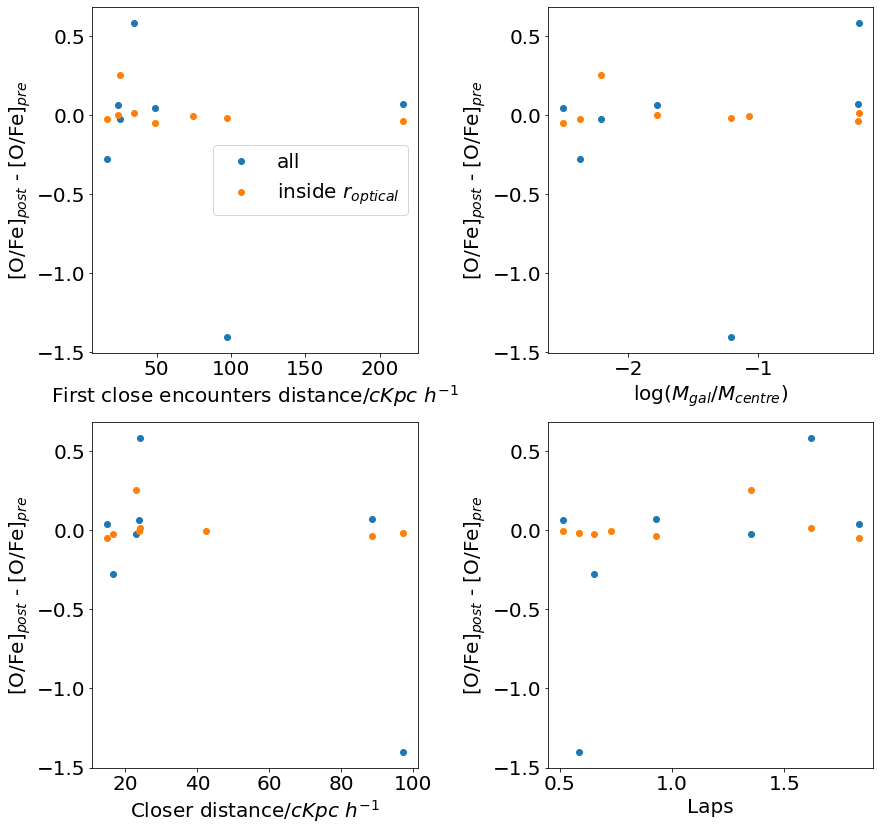

In [22]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.4)

pl.subplot(2, 2, 1)

pl.plot(periDist, difOFe, marker='o', ls=' ', label='all')
pl.plot(periDist, difOFe_optical, marker='o', ls=' ', label='inside $r_{optical}$')

pl.legend(loc='best')

pl.xlabel('First close encounters distance/$cKpc\,\,h^{-1}$')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

pl.subplot(2, 2, 2)

pl.plot(np.log10(MassRatio), difOFe, marker='o', ls=' ')
pl.plot(np.log10(MassRatio), difOFe_optical, marker='o', ls=' ')

pl.xlabel('$\log(M_{gal}/M_{centre})$')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

pl.subplot(2, 2, 3)

pl.plot(minDist, difOFe, marker='o', ls=' ')
pl.plot(minDist, difOFe_optical, marker='o', ls=' ')

pl.xlabel('Closer distance/$cKpc\,\,h^{-1}$')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')

pl.subplot(2, 2, 4)

pl.plot(NLaps, difOFe, marker='o', ls=' ')
pl.plot(NLaps, difOFe_optical, marker='o', ls=' ')

pl.xlabel('Laps')
pl.ylabel('[O/Fe]$_{post}$ - [O/Fe]$_{pre}$')